## Excercise 1: Clustering based on multinomial mixture model

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import Binarizer


In [40]:
"""
1. Initialize k jk random.
 2. For t = 12
 (a) For = 1
 (b) For k = 1
 (c) For k = 1
 N compute k = argmaxkp(x k)
 K compute Nk. Set k := NkN
 K j=1 dcomputemjk. Set jk =mjk
"""

class MixtureModel:
    """
    Class for making a Multinomial Mixture model for clustering data.
    """
    def __init__(self, clusters:int, features:int, data):
        self.clusters = clusters
        self.features = features 
        self.data = data

        self.pi = np.random.rand(clusters)
        self.pi /= self.pi.sum()
        self.pi = np.reshape(self.pi, (10,1))

        self.mu_jk = np.random.rand(clusters, features)

    def logprob_data_given_clusters(self):
        """
        Calculates the log probability of each data point given each cluster
        """
        epsilon = 1e-10
        self.mu_jk = np.clip(self.mu_jk, epsilon, 1 - epsilon)
        pxsk = self.data@np.log(self.mu_jk).T + (1-self.data)@np.log(1-self.mu_jk).T
        return pxsk
    
        
    def k_mu(self):
        """
        Computes the log probability of each data point given each cluster, then takes the arg-max over the clusters.
        """
        pxk = np.log(self.pi).T + self.logprob_data_given_clusters()
        return np.argmax(pxk, axis=1, keepdims=True)
    
    def delta_func(self, k, kmu):
        """
        Returns a vector corresponding to the dirac delta function for the assignation of data points to clusters (kmu), and the clusters.
        """
        ks = np.full_like(kmu, k)
        return np.where(ks == kmu, 1, 0)
    
    def N_k(self, kmu):
        """
        Computes the number of data points assigned to each cluster k
        """
        N_k = np.ones((self.clusters, 1))
        for k in range(self.clusters):
            # adding by 1 to ensure no division by 0
            N_k[k] = np.sum(self.delta_func(k, kmu)) + 1

        return N_k
    
    def set_pi_k(self, N_k):
        """
        Updates the parameter for pi_k
        """
        self.pi  = (N_k+1)/(self.data.shape[0] +1)
    
    def m_jk(self, N_k, kmu):
        """
        Computes updated parameters mu_jk
        """
        m = np.zeros_like(self.mu_jk)
        for j in range(self.features):
            for k in range(self.clusters):
                m[k, j] = np.sum(self.data[:,j]*self.delta_func(k, kmu).T)

        m = m/N_k
        m = np.nan_to_num(m)
        m = np.where(m==0, np.random.rand(self.clusters, self.features), m)

        return m
    
    def plot(self):
        plt.figure(figsize=(10, 10))
    
        for i in range(self.clusters):
            image = self.mu_jk[i].reshape((28,28))
            # denormalization
            image = image*255

            plt.subplot(1, self.clusters, i + 1)
            plt.imshow(image, cmap='gray')
            plt.title("%.4f" %self.pi[i].item())
        
        plt.show()

    
    def run_model(self, max_iter = 150):
        """
        Runs the Multinomial mixture algorithm on the data
        """
        epsilon = 1e-6

        for t in range(max_iter):
            k_mu = self.k_mu()
            # Diagnostic for argmax function:
            unique, counts = np.unique(k_mu, return_counts=True)
            # print(dict(zip(unique, counts)))

            N_k = self.N_k(k_mu)
            m_jk = self.m_jk(N_k, k_mu)
            self.set_pi_k(N_k)
            if np.allclose(self.mu_jk, m_jk, epsilon):
                print(f"Cluster algorithm converged in {t} iterations")
                break
            self.mu_jk = m_jk
        self.plot()
        return

In [41]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.int32).values
y = mnist.target.astype(np.int32)

binarizer = Binarizer(threshold=127)
X_bin = binarizer.fit_transform(X)

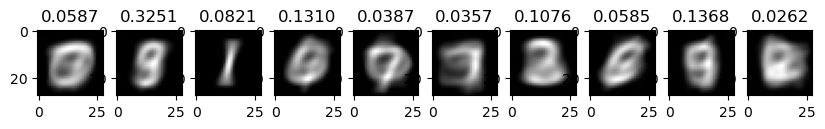

In [42]:
MM = MixtureModel(10, X.shape[1], X)
MM.run_model()

## Excercise 3: EM algorithm on Old Faithful Geyser

In [43]:
import pandas as pd
from scipy.stats import multivariate_normal

import numpy as np
import matplotlib.pyplot as plt

In [44]:
def plot_gaussian(mu, cov, ax, color):
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # Define the multivariate normal distributions
    rv1 = multivariate_normal(mu, cov)

    # Calculate the PDF (probability density function) over the grid
    Z1 = rv1.pdf(pos)

    ax.contour(X, Y, Z1, levels=[0.1], colors=color)


def plot_data(data, mu, cov):
    fig, ax = plt.subplots()
    ax.scatter(data[:, 0], data[:, 1], s=10, c='green', label='Samples')

    plot_gaussian(mu[0], cov[0], ax, color='blue')
    plot_gaussian(mu[1], cov[1], ax, color='red')

    # Set the plot limits and labels
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')

    plt.show()

def plot_classified_data(data, mu, cov, r_k):
    fig, ax = plt.subplots()

    # Assign each point to the cluster with the highest responsibility
    cluster_assignments = np.argmax(r_k, axis=0)
    cluster_0 = data[cluster_assignments == 0]
    cluster_1 = data[cluster_assignments == 1]

    # Plot colored sata points
    ax.scatter(cluster_0[:, 0], cluster_0[:, 1], s=20, c='blue', label='Cluster 0')
    ax.scatter(cluster_1[:, 0], cluster_1[:, 1], s=20, c='red', label='Cluster 1')

    # Plot the Gaussian distributions as contours
    plot_gaussian(mu[0], cov[0], ax, color='blue')
    plot_gaussian(mu[1], cov[1], ax, color='red')

    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_aspect('equal')

    plt.legend()
    plt.show()


def prep_data():
    data = pd.read_csv('old_faithful_geyser.txt', delim_whitespace=True, header=None, index_col=0).to_numpy()

    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)

    # Perform the standardization
    standardized_data = (data - mean) / std_dev
    return standardized_data


def gaussian_with_pi_k(pi_probability, big_sigma, a, X):
    """
    Calculates the joint probability of the prior for the classes and the multivariate Gaussian for the data for that class

    :param pi_probability: prior for the classes
    :param big_sigma: covariance matrix for the Gaussian
    :param a: mean vector for the Gaussian
    :param X: data points
    """
    return pi_probability * multivariate_normal.pdf(X, mean=a, cov=big_sigma)

def multi_cluster_gaussian_with_pi_k(pi_k, big_sigma_k, a_k, X, k):
    gaussians_with_pi = []
    # calculating enumerators of both clusters of responsibilities
    for i in range(k):
        gaussians_with_pi.append(gaussian_with_pi_k(pi_k[i], big_sigma_k[i], a_k[i], X))
    return gaussians_with_pi


def E_step(pi_k, big_sigma_k, X, a_k, k):
    gaussians_with_pi = multi_cluster_gaussian_with_pi_k(pi_k, big_sigma_k, a_k, X, k)

    # calculating responsibilities for both clusters
    r_k = []
    for gaussian_pi in gaussians_with_pi:
        r_k.append(gaussian_pi / sum(gaussians_with_pi))

    return r_k


def M_step(r_k, X):
    # I always reference with k if that contains information about both clusters,
    # otherwise I use letter without k
    n = len(X)
    pi_k = []
    big_sigma_k = []
    a_k = []
    # iterate over clusters
    for i, r in enumerate(r_k):
        sum_of_r = sum(r)

        # updating pi
        new_pi = sum_of_r / n
        pi_k.append(new_pi)

        # updating mean
        new_a = (1 / sum_of_r) * (r @ X)
        a_k.append(new_a)

        # updating variance
        diff = X - new_a
        weighted_diff = diff.T * r
        new_cov = np.dot(weighted_diff, diff) / sum_of_r
        big_sigma_k.append(new_cov)

    return pi_k, big_sigma_k, a_k

def calc_likelihood(pi_k, big_sigma_k, a_k, X, k):
    gaussians_with_pi = multi_cluster_gaussian_with_pi_k(pi_k, big_sigma_k, a_k, X, k)
    log_likelihood = sum(np.log(sum(gaussians_with_pi)))
    return log_likelihood

C:\Users\stian\AppData\Local\Temp\ipykernel_40436\757406557.py:57: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('old_faithful_geyser.txt', delim_whitespace=True, header=None, index_col=0).to_numpy()


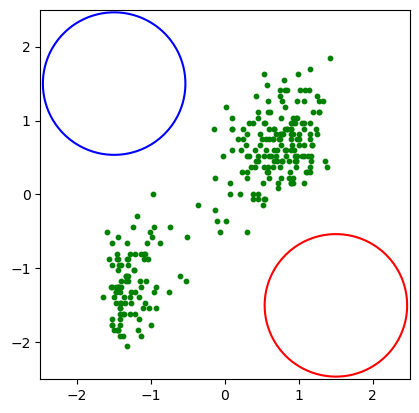

542.9830737056209


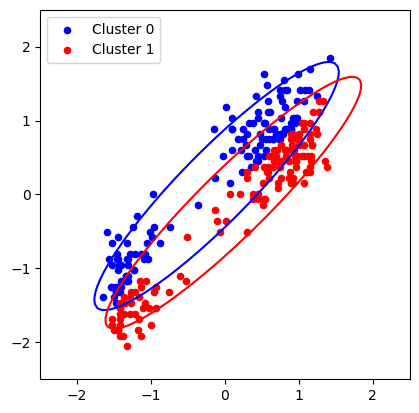

0.39022966055802044
0.14974945618905622
0.08725783466400117
0.06848557075738881
0.06095677431369495
0.05651324772975386
0.052948964361917206
0.04966085548448973
0.04652834509920467
0.04358809282950915
0.040929891625069104
0.03866162305951093
0.03689801888060629


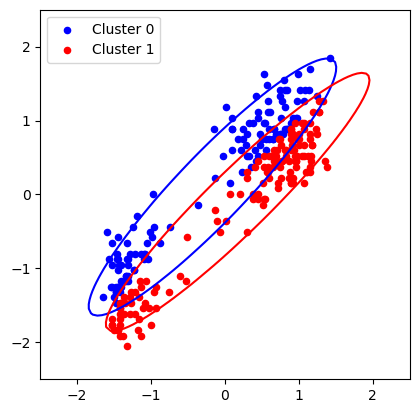

0.03575919311083453
0.035374988986518474
0.035894686167466716
0.0375031952783047
0.040446302297709735
0.0450697850171764
0.05188137194238607
0.0616524831876859
0.07559264552435252
0.0956630218340706
0.12517019903384607
0.16995898653408403
0.24097852457009594


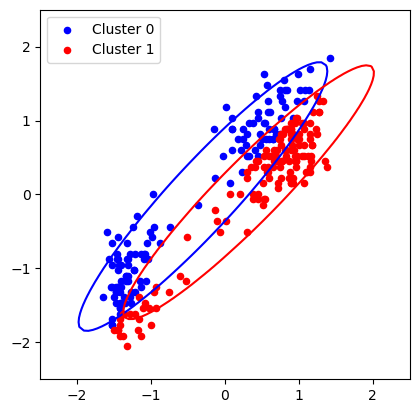

0.36027339194299657
0.5764327318088363
1.009588194956109
2.0031286144701426
4.71843797356712
13.413290150233024
33.72543528036471
24.32259231394272
6.667834047200529
4.365940447284515
4.72233866313934
6.207534637281071
8.81478704165113


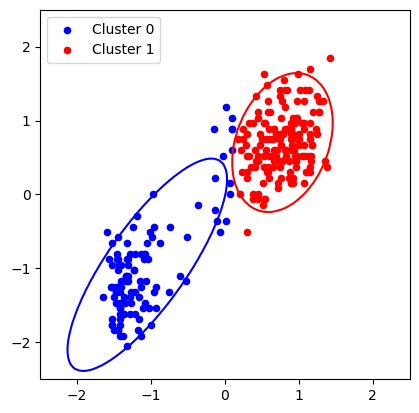

12.602537253821026
14.831768266398683
11.744401813916511
4.910231163467358
0.34017656154401266
0.0116575556008911
0.0006021495223649254
3.402389626216973e-05
1.960343922746688e-06
stopped after iteration 49


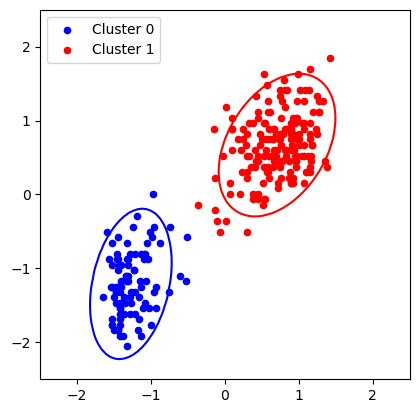

In [48]:
# starting main code:
data = prep_data()

# initialization of values
k = 2
pi_k = np.array([1 / k, 1 / k])

# starting from the values that were given in the book so that we have a matching graph
# mu = np.array([[-1, 1], [1, -1]])
mu = np.array([[-1.5, 1.5], [1.5, -1.5]])
cov = np.array([np.eye(2), np.eye(2)])

# visualizing initial data
plot_data(data, mu, cov)

epsilon = 0.00001
previous_likelihood = 0
# EM iteration
for i in range(60):
    responsibilities = E_step(pi_k, cov, data, mu, k)
    pi_k, cov, mu = M_step(responsibilities, data)
    likelihood = calc_likelihood(pi_k, cov, mu, data, k)
    delta = abs(likelihood - previous_likelihood)
    previous_likelihood = likelihood
    print(delta)
    if i % 13 == 0:
        plot_classified_data(data, mu, cov, responsibilities)
    if epsilon >= delta:
        break

print(f'stopped after iteration {i+1}')
#
plot_classified_data(data, mu, cov, responsibilities)